# Q8 Analyze HRV

Dig into the Rhinovirus results in the Q8 sequencing run.

In prior RespiCoV analyses I've relied on hits caching to enable fast analysis. But in Q8 I have a ton more data (28 Gb uncompressed, 22M reads) using a variety of different primers, as well as a lot of samples using only Rhinovirus primers. So rather than use hits caching, let's just split out the entire set of Rhinovirus hits and operate on that. 

This looks over all sequencing reads for the HRV 5' UTR region targetted by the RespiCoV Enterovirus primer pair. Most experiments actually used the HRVKa5 primer set, but they different from ENT rc only in the reverse primer extending 2 bases further beyond the amplicon, so we can just ignore that.

Note that these samples also include a full-genome HRV sequence which we want to exclude.
Reads were basecalled and demuxed with Dorado 0.7.3, using the sup@v5.0.0 model and without barcodes and adapters trimming.
Reads have not yet been filtered for quality, we do that here.

## Setup

In [35]:
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random
import numpy as np
import Bio

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Be deterministic
random.seed(42)

fastQDir = "../Q8/reads-sup/"
hrvDir = "../Q8/reads-sup-hrv/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

print("BioPython version:", Bio.__version__)

# Get the Rhinovirus primer pair.
rcPrimers = RCUtils.readPrimers("RespiCovPrimers.fasta")
hrvPrimers = [p for p in rcPrimers if p.description == "Rhinovirus/Enterovirus 1" or p.description == "Rhinovirus/Enterovirus 3"]
barcodes = RCUtils.readPrimers("ONTBarcodes.fasta", addRc=False, addRandom=False)
adapters = RCUtils.readPrimers("ONTAdapters.fasta", addRc=False, addRandom=False)
print("Rhinovirus primers:", [str(p.seq) for p in hrvPrimers])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
BioPython version: 1.80
Rhinovirus primers: ['CAAGCACTTCTGTTTCCCCGG', 'AACACGGACACCCAAAGTAGT']


## Utilities

In [128]:
import math

# Get the hits across all files but allow a limit on the number of reads per file.
# Many files have over a million reads.
def getAllPrimerHits(maxReadsPerFile = 0, progress = False, skipReads = 0):
    for file in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(fastQDir))):
        for (read, hit) in getPrimerHits(file, maxReadsPerFile, progress, skipReads):
            yield (file, read, hit)

# Get primer hits for a single file
def getPrimerHits(file, maxReadsPerFile = 0, progress = False, skipReads = 0, matchThreshold = RCUtils.MATCH_THRESHOLD, primers=hrvPrimers):
    fastQPath = os.path.join(fastQDir, file)
    if not os.path.exists(fastQPath) and os.path.exists(fastQPath + ".gz"):
        fastQPath += ".gz"
    if progress:
        print("Processing ", os.path.basename(fastQPath), end="")
    reads = 0
    hitReads = 0
    for read in RCUtils.readFastQ(fastQPath):
        reads += 1
        if reads <= skipReads:
            continue
        hits = RCUtils.computePrimerHits(read, primers, matchThreshold=matchThreshold)
        if hits:
            hitReads += 1
            yield (read, hits)
        if maxReadsPerFile and reads >= skipReads + maxReadsPerFile:
            break
    if progress:
        totalReads = max(reads - skipReads, 0)
        print(" %d reads, %d with hits (%d%%)" % (totalReads, hitReads, hitReads * 100 / totalReads if totalReads else 0))

# Compute an overall probability of error as a phred score
# This tends to higly penalize a single error, so may not be as useful as the mean phred score
def overallPhredScore(phred_scores):
    # Phred scores represent the probability of error, eg. with 10 being 1 in 10, 20 being 1 in 100, etc.
    total_error_prob = 1 - math.prod(1 - 10 ** (-q / 10) for q in phred_scores)
    if total_error_prob == 0:
        return float('inf')
    return -10 * math.log10(total_error_prob)

# Print an alignment with an additional track indicating the quality scores of the read
def printAlignmentWithQuality(alignment, read):
    assert(alignment.target is read.seq)
    quality_scores = read.letter_annotations["phred_quality"]
    
    # Initialize strings for the aligned target, query, alignment string, and query quality scores
    aligned_target = ""
    aligned_query = ""
    alignment_string = ""
    aligned_target_quality = ""
    
    # Use indices to determine where gaps are and construct the alignment, target, query, and quality strings

    for t_index, q_index in zip(*alignment.indices):
        aligned_target += alignment.target[t_index] if t_index != -1 else "-"
        aligned_query += alignment.query[q_index] if q_index != -1 else "-"
        alignment_string += "|" if t_index != -1 and q_index != -1 and alignment.target[t_index] == alignment.query[q_index] else "."
        if t_index == -1:
            aligned_target_quality += "-"
        else:
            ns = quality_scores[t_index] // 4
            aligned_target_quality += str(ns) if ns < 10 else "9"

    tstart = alignment.indices[0,0]
    tend = alignment.indices[0,-1]
    print("  target quality     ", aligned_target_quality, "  avg:", int(np.mean(quality_scores[tstart:tend])))
    print("  target             ", aligned_target)
    print("                     ", alignment_string)
    print("  query              ", aligned_query)
    print("")

# Print the hits for a read
def printHits(read, hits):
    print ("%s %d" % (read.id, len(read)))
    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
        aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
        alignment = aligner.align(read.seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0]
        RCUtils.extendAlignment(alignment)
        printAlignmentWithQuality(alignment, read)

# Function to parse a UCLUST-like file
def parseUclust(input_file):
    clusters = {}
    cluster_order = []
    with open(input_file, 'r') as f:
        for line in f:
            columns = line.strip().split('\t')
            cluster_id = int(columns[1])
            if columns[0] == 'S':
                # Initialize a new cluster entry for a centroid record
                clusters[cluster_id] = {
                    'id': cluster_id,
                    'centroid': {
                        'length': int(columns[2]),
                        'readId': columns[8],
                    },
                    'hits': [],
                    'cluster_size': 0
                }
            elif columns[0] == 'H':
                # Append hit information to the corresponding cluster
                clusters[cluster_id]['hits'].append({
                    'length': int(columns[2]),
                    'similarity': columns[3],
                    'orientation': columns[4],
                    'readId': columns[8],
                })
            elif columns[0] == 'C':
                clusters[cluster_id]['cluster_size'] = int(columns[2])
                cluster_order.append(cluster_id)
    return (clusters, cluster_order)

## Get an idea for the distribution of reads with hits

Barcodes 1 to 7 are our main HRV samples and as expected have the bulk of the hits.
Barcodes 19-21 are RespiCoV and so are expected to have some HRV.
Barcode 18 is the HRV-C1 full genome. Why don't we see hits here? Shouldn't I have to filter out these ~1200bp HRV hits?
A few of the other hits occur in samples using other RespiCov primers but not HRV, why?

In [4]:
hitCount = 0
for (inFile, read, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True):
    hitCount += len(hits)

print("Total hits:", hitCount)

Processing  Q8-sup_barcode01.fastq 1000 reads, 968 with hits (96%)
Processing  Q8-sup_barcode02.fastq 1000 reads, 900 with hits (90%)
Processing  Q8-sup_barcode03.fastq 1000 reads, 953 with hits (95%)
Processing  Q8-sup_barcode04.fastq 1000 reads, 883 with hits (88%)
Processing  Q8-sup_barcode05.fastq 1000 reads, 926 with hits (92%)
Processing  Q8-sup_barcode06.fastq 1000 reads, 923 with hits (92%)
Processing  Q8-sup_barcode07.fastq 1000 reads, 980 with hits (98%)
Processing  Q8-sup_barcode08.fastq 1000 reads, 0 with hits (0%)
Processing  Q8-sup_barcode09.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode10.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode11.fastq 1000 reads, 11 with hits (1%)
Processing  Q8-sup_barcode12.fastq 1000 reads, 411 with hits (41%)
Processing  Q8-sup_barcode13.fastq 1000 reads, 4 with hits (0%)
Processing  Q8-sup_barcode14.fastq 1000 reads, 124 with hits (12%)
Processing  Q8-sup_barcode15.fastq 1000 reads, 1 with hits (0%)
Processing  

## Look at the first few hits in detail just to sanity check

These look good. Primer pair hits at the exact start and end of the trimmed read.
Mismatches seem to be in areas of low basecall quality.

In [6]:
from Bio import Align

for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=5):
    printHits(read, hits)


90356f32-2337-4543-a50b-390d2113b4af 448
   0.95 72-93: Rhinovirus/Enterovirus 1 (21)
target quality      999999999998898644347   avg: 35
target              CAAGCACTTCTGTTTCCCGGG
                    ||||||||||||||||||.||
query               CAAGCACTTCTGTTTCCCCGG

cf7c2352-560f-403a-9f50-9066bdfe5c37 177
   1.00 105-126: Rhinovirus/Enterovirus 1 (21 rev)
target quality      111167677656666677777   avg: 22
target              CCGGGGAAACAGAAGTGCTTG
                    |||||||||||||||||||||
query               CCGGGGAAACAGAAGTGCTTG

41b68922-77da-43c7-a560-1d0c71435abf 329
   1.00 80-101: Rhinovirus/Enterovirus 3 (21)
target quality      999999999999878855555   avg: 32
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT

0194b466-3014-478a-9456-09293a0e052f 523
   0.90 80-100: Rhinovirus/Enterovirus 1 (21)
target quality      999999999899992268187   avg: 36
target              CAAGCACTTCTGTTTCCCGGT
                 

## Match score distributions

We're using a default match threshold of 0.8. Make sure that still looks reasonable by comparing the distribution beyond that.
This looks only at the start of one barcode group, it will vary later in the read sequence. This (along with the examples above) also confirms that we'd be throwing away a lot of good matches if we required an exact match.
This looks to be meaningfully better than my first attempt with the hac basecaller - 12,311 perfect hits instead of 9.358, a 32% improvement.

12311 of 20794 (59%) of primer hits are a perfect match


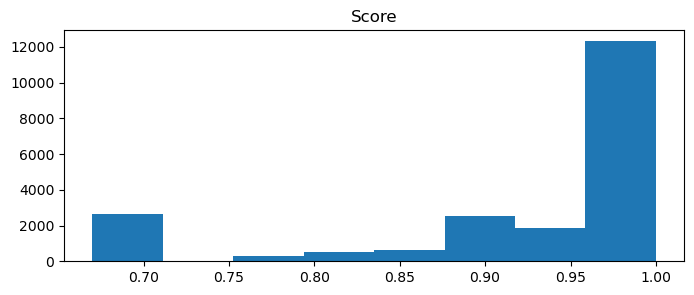

In [7]:
mrs = []
perfect = 0
for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=10000, matchThreshold = 0.65):
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=8, grid=False);

## Read prefixes and suffxies

We expect to see an adapter, barcode and primer at the start and end of many reads, and barcode and primer at the end.
Sanity check this for one of the first reads (most others seem similar). 

In [36]:
for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=1, skipReads=3, primers=adapters+barcodes+hrvPrimers):
    printHits(read, hits)

0194b466-3014-478a-9456-09293a0e052f 523
   0.89 3-40: LAt (36)
target quality      1111111110111112255579999999999999988   avg: 21
target              TTTGTGTCTTCTGTACTTCGTTCAGTTACGTATTGCT
                    |||.|.|.|.|||||||||||||||||||||||||||
query               TTTTTTT-TCCTGTACTTCGTTCAGTTACGTATTGCT

   1.00 40-80: NB01f (40)
target quality      9889999999999999999999999999999999999999   avg: 41
target              AAGGTTAACACAAAGACACCGACAACTTTCTTCAGCACCT
                    ||||||||||||||||||||||||||||||||||||||||
query               AAGGTTAACACAAAGACACCGACAACTTTCTTCAGCACCT

   0.90 80-100: Rhinovirus/Enterovirus 1 (21)
target quality      999999999899992268187   avg: 36
target              CAAGCACTTCTGTTTCCCGGT
                    ||||||||||||||||||.|.
query               CAAGCACTTCTGTTTCCCCGG

   1.00 453-474: Rhinovirus/Enterovirus 3 (21 rev)
target quality      666699998899999999999   avg: 41
target              ACTACTTTGGGTGTCCGTGTT
                    |||||||||||||||||||||


## Distribution of read lengths with hits.

HRV amplicons are expected to be about 390. But we expect 40bp & 45bp barcodes and a 36bp adapter.

Median length: 514, expected 514
Reads with at least 2 hits: 8101, length 464-564: 7956 (98%)


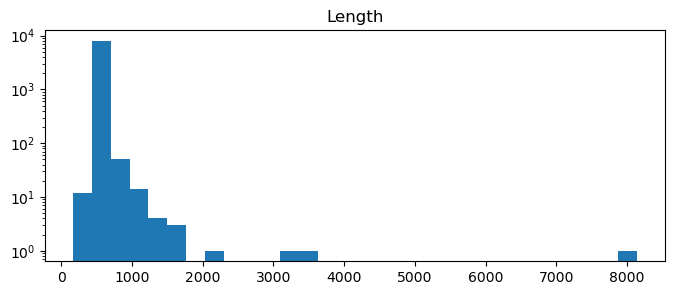

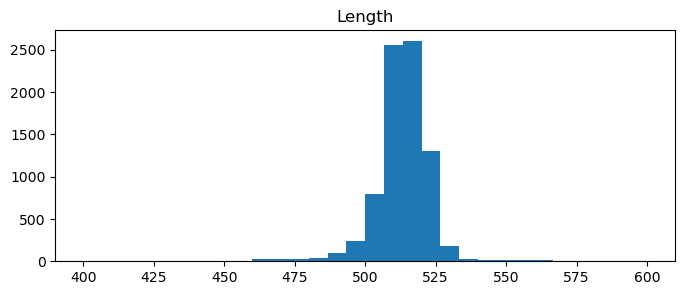

In [52]:
import matplotlib.pyplot as plt

EXPECTED_AMPLICON_LENGTH = 390
EXPECTED_PREFIX = 36 + 40 + 3
EXPECTED_SUFFIX = 45
EXPECTED_READ_LENGTH = EXPECTED_AMPLICON_LENGTH + EXPECTED_PREFIX + EXPECTED_SUFFIX
LENGTH_TOLERANCE = 50

def plotLengths(fastq):
    lens = []
    reads = 0
    withinTol = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=10000):
        if len(hits) < 2:
            continue
        reads += 1
        if abs(len(read) - EXPECTED_READ_LENGTH) < LENGTH_TOLERANCE:
            withinTol += 1
        lens.append(len(read))

    print("Median length: %d, expected %d" % (np.median(lens), EXPECTED_READ_LENGTH))
    print("Reads with at least 2 hits: %d, length %d-%d: %d (%d%%)" % 
          (reads, 
          EXPECTED_READ_LENGTH - LENGTH_TOLERANCE,
          EXPECTED_READ_LENGTH + LENGTH_TOLERANCE, 
          withinTol, 
          100*withinTol/reads))

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, range=(400, 600))
    plt.show()

plotLengths("Q8-sup_barcode01.fastq")

Check one of the mess full RespiCoV samples too. It's quite different, but that's probably due to primer-dimers and other artifacts. 

Median length: 1120, expected 514
Reads with at least 2 hits: 129, length 464-564: 7 (5%)


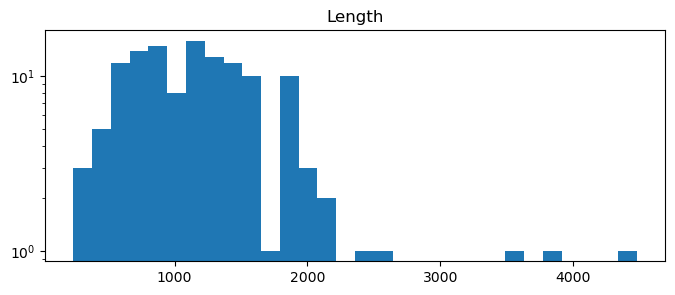

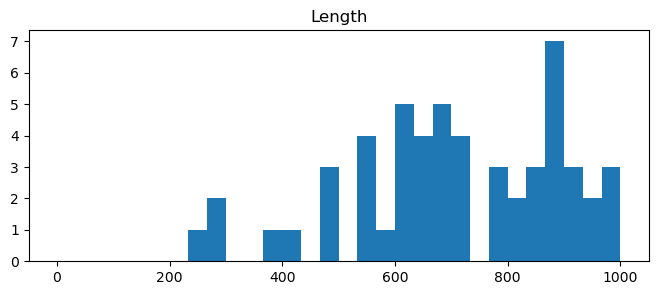

In [40]:
plotLengths("Q8-sup_barcode20.fastq")

## Distribution of hit locations

Perhaps we could make things a lot faster by looking only at the start and end of the read for hits? With dorado having done read splitting for us, perhaps we can skip barcodes and adapters and all find all legit primers at the start and end of reads?

Hits: 15914, exact: 365 (2%), within 20: 15782 (99%)


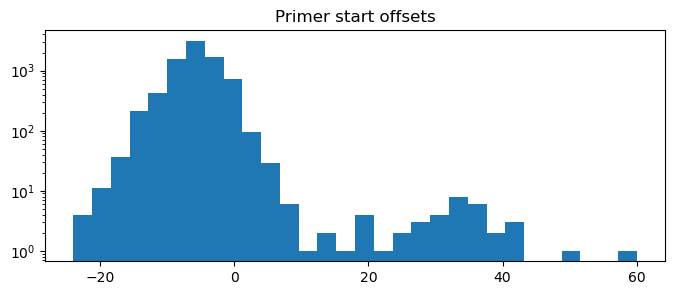

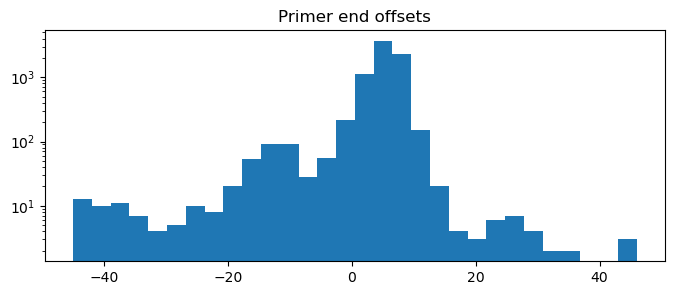

In [232]:
MAX_PRIMER_OFFSET = 20

def plotHitOffsets(fastq, maxReadsPerFile=10000):
    sos = []
    eos = []
    hitCount = 0
    exactHit = 0
    withinTol = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=maxReadsPerFile):
        if len(hits) < 2:
            continue
        if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
            continue
        for hit in hits:
            hitCount += 1
            so = hit.start - EXPECTED_PREFIX
            eo = len(read) - EXPECTED_SUFFIX - hit.end
            if min(so, eo) == 0:
                exactHit += 1
            if min(abs(so), abs(eo)) <= MAX_PRIMER_OFFSET:
                withinTol += 1
            if (abs(so) < abs(eo)):
                sos.append(so)
            else:
                eos.append(eo)

    print("Hits: %d, exact: %d (%d%%), within %d: %d (%d%%)" % (hitCount, exactHit, 100*exactHit/hitCount, MAX_PRIMER_OFFSET, withinTol, 100*withinTol/hitCount))
    df = pd.DataFrame({'Primer start offsets': sos})
    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    df = pd.DataFrame({'Primer end offsets': eos})
    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)

plotHitOffsets("Q8-sup_barcode01.fastq")

And again on a RespiCov sample (but most hits are something else so process 10x more reads)

Hits: 313, exact: 11 (3%), within 20: 236 (75%)


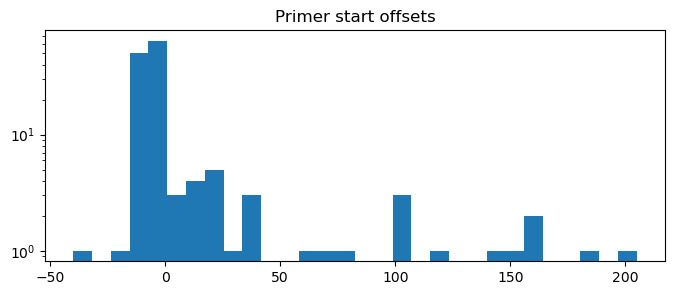

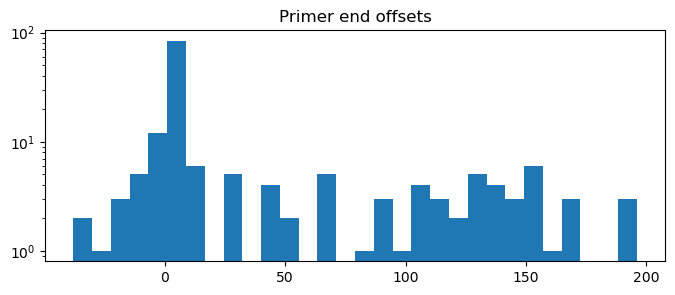

In [233]:
plotHitOffsets("Q8-sup_barcode21.fastq", maxReadsPerFile=100000)

## Distribution of read qualities

We need a threshold for filtering out low-quality reads. Let's take a look at a sample distribution.
Note that this is shifted right significantly from the HAC basecaller (peak around Q18 with hac, Q28 here with sup).

Reads: 7957, qual p5: 19, qual reads: 7841 (98%)


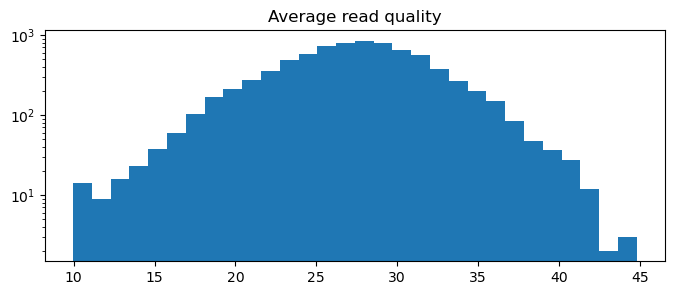

In [54]:
avgQuals = []
reads = 0
qualReads = 0
MIN_QUAL = 16

for (read, hits) in getPrimerHits("Q8-sup_barcode01.fastq", maxReadsPerFile=10000):
    if len(hits) < 2:
        continue
    if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
        continue
    reads += 1
    aq = np.mean(read.letter_annotations["phred_quality"])
    avgQuals.append(aq)
    if (aq >= MIN_QUAL):
        qualReads += 1

print ("Reads: %d, qual p5: %d, qual reads: %d (%d%%)" % (reads, np.percentile(avgQuals, 5), qualReads, 100*qualReads/reads))
df = pd.DataFrame({'Average read quality': avgQuals})
ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
plt.show()


# Make cached HRV read files with optimized hit finding

Based on the above we can search just for primers at the start and end of reads, and with reads of at least Q16, and save them to their own files.

In [236]:
import gzip
from Bio import SeqIO
import time
maxPrimer = max([len(p.seq) for p in hrvPrimers])
fs = EXPECTED_PREFIX - MAX_PRIMER_OFFSET
fe = EXPECTED_PREFIX + MAX_PRIMER_OFFSET + maxPrimer
rs = - EXPECTED_SUFFIX - MAX_PRIMER_OFFSET - maxPrimer
re = - EXPECTED_SUFFIX + MAX_PRIMER_OFFSET
readsByFile = {}
hitsByFile = {}

print("Trimming to %d-%d and %d-%d" % (fs, fe, rs, re))

for inFile in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(fastQDir))):
    hrvFile = os.path.join(hrvDir, "HRV-" + inFile)
    if os.path.exists(hrvFile):
        print("Skipping existing file:", hrvFile)
        # TODO still compute counts
        continue
    # Extract the portion of the filename after the _ and before the .
    fnSuffix = inFile.split("_")[1].split(".")[0]

    with open(hrvFile, "wt") as out:
        inPath = os.path.join(fastQDir, inFile)
        print("Processing", os.path.basename(inPath), end="")
        reads = 0
        hitReads = 0
        ai = time.process_time()
        for read in RCUtils.readFastQ(inPath):
            reads += 1
            if reads % 10000 == 0:
                print(".",end="")

            if abs(len(read) - EXPECTED_READ_LENGTH) > LENGTH_TOLERANCE:
                continue
            
            aq = np.mean(read.letter_annotations["phred_quality"])
            if aq < MIN_QUAL:
                continue

            # Look for a primer hit at the start and end of the read
            startHits = RCUtils.computePrimerHits(read[fs:fe], hrvPrimers)
            if not startHits:
                continue
            startHit = startHits[-1]
            endHits = RCUtils.computePrimerHits(read[rs:re], hrvPrimers)
            if not endHits:
                continue
            endHit = endHits[0]
            
            # One primer should be the forward one and one should be reverse
            if startHit.primer is endHit.primer:
                continue

            hitReads += 1

            # Trim the read to the primer hits and add the barcode
            origQual = read.letter_annotations["phred_quality"]
            read.letter_annotations = {}
            read.seq = read.seq[fs+startHit.start:rs+endHit.end]
            read.letter_annotations["phred_quality"] = origQual[fs+startHit.start:rs+endHit.end]
            read.id = read.id + "_" + fnSuffix

            # If the primer is the reverse primer, reverse complement the read
            if startHit.primer.description == "Rhinovirus/Enterovirus 3":
                read.seq = read.seq.reverse_complement()
                read.letter_annotations["phred_quality"] = read.letter_annotations["phred_quality"][::-1]
                
            SeqIO.write(read, out, "fastq")

        elapsed = time.process_time() - ai
        print("")
        print("  %d reads, %d with hits (%d%%). %.2fs" % (reads, hitReads, hitReads * 100 / reads if reads else 0, elapsed))
        readsByFile[fnSuffix] = reads
        hitsByFile[fnSuffix] = hitReads


Trimming to 59-120 and -86--25
Processing Q8-sup_barcode01.fastq............................................................................................................................................................
  1569821 reads, 1234718 with hits (78%). 286.38s
Processing Q8-sup_barcode02.fastq.............................
  294013 reads, 232364 with hits (79%). 52.59s
Processing Q8-sup_barcode03.fastq...........................................................................
  755149 reads, 634005 with hits (83%). 140.96s
Processing Q8-sup_barcode04.fastq...............................
  311277 reads, 247643 with hits (79%). 55.24s
Processing Q8-sup_barcode05.fastq.........................................
  415175 reads, 345963 with hits (83%). 76.77s
Processing Q8-sup_barcode06.fastq...................................................
  510326 reads, 423580 with hits (83%). 93.93s
Processing Q8-sup_barcode07.fastq...............................................................

There's often multiple hits, check out a few to make sure they match the expected pattern of outer concatemers. 

In [63]:
for read in RCUtils.readFastQ(os.path.join(fastQDir, "Q8-sup_barcode01.fastq")):
    if read.id == "8a73e783-6db7-4857-b5a8-f06a5f58cadc" or \
        read.id == "2e53d223-7b5d-4738-8deb-e8da5522caf8" or \
        read.id == "ead570db-492a-4f58-ade9-382ae910c82b":
        hits = RCUtils.computePrimerHits(read, hrvPrimers)
        printHits(read, hits)
        if read.id == "ead570db-492a-4f58-ade9-382ae910c82b":
            break

8a73e783-6db7-4857-b5a8-f06a5f58cadc 539
   1.00 75-96: Rhinovirus/Enterovirus 1 (21)
target quality      987899999999999899969   avg: 39
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 97-118: Rhinovirus/Enterovirus 1 (21)
target quality      987899999999999899969   avg: 39
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 467-488: Rhinovirus/Enterovirus 3 (21 rev)
target quality      999777779999999999999   avg: 41
target              ACTACTTTGGGTGTCCGTGTT
                    |||||||||||||||||||||
query               ACTACTTTGGGTGTCCGTGTT

2e53d223-7b5d-4738-8deb-e8da5522caf8 540
   1.00 75-96: Rhinovirus/Enterovirus 1 (21)
target quality      999999999999999999999   avg: 42
target              CAAGCACTTCTGTTTCCCCGG
                    |||||||||||||||||||||
query               CAAGCACTTCTGTTTCCCCGG

   1.00 96-117:

Plot the number of matches for each barcode

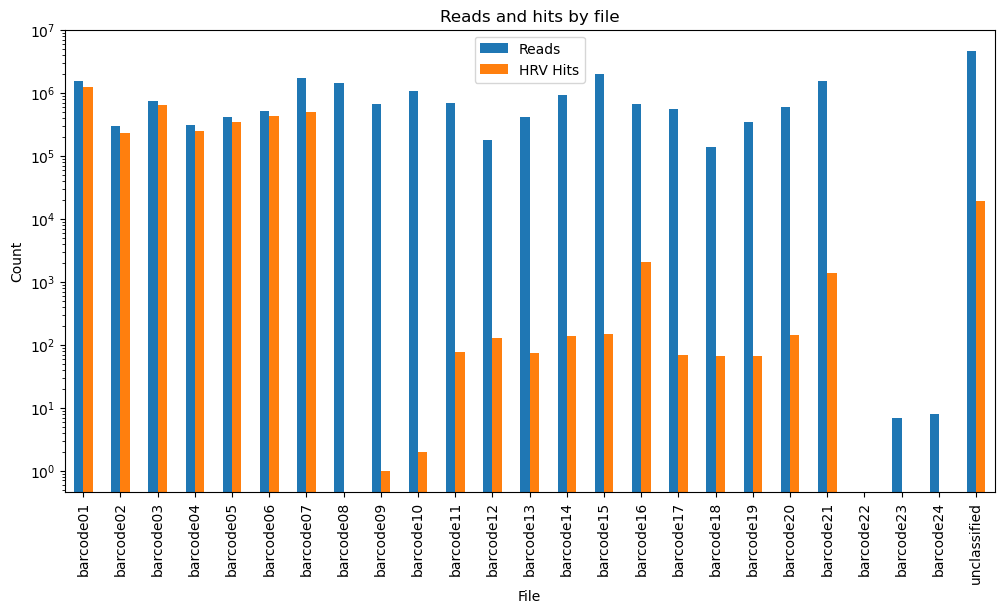

In [319]:
# Plot a chart of the number of reads and hits for each file
df = pd.DataFrame({'Reads': readsByFile, 'HRV Hits': hitsByFile})
ax = df.plot.bar(figsize=(12,6), grid=False, title="Reads and hits by file")
ax.set_xlabel("File")
ax.set_ylabel("Count")
ax.set_yscale('log')
plt.show()


Barcode 1-7 are our HRV samples, so a high match rate there is expected. Some amount of barcode mismatch is expected (eg. chimeric reads). Barcode 19-21 are RespiCoV samples and so are expected to have a lot of junk, but perhaps they have some real HRV as well beyond the noise of mis-barcoding?

# Cluster the HRV reads
Since barcoding isn't perfectly reliable and I have some barcodes that may have mixed HRV targets anyway, try to look at the HRV reads without respect to their barcodes and see what groups we can find. This is apparently hard with nanopore reads due to the high error rate (even with sup basecalling). 

Cluster the results by pairwise similarity using the VSearch program. Use a low identity threshold to start, we can always split clusters further. Clustering is expensive and it's nice to be able to watch the progress. So rather than execute here directly, just copy the results from a terminal


```text
cd ../Q8/reads-sup-hrv
rm clusters/*
cat HRV-Q8-sup_*.fastq | ../../vsearch-2.28.1-macos-aarch64/bin/vsearch --cluster_size - --id 0.70 --centroids clusters/centroids.fasta --uc clusters/clusters.uc --consout clusters/consensus.fasta --clusterout_sort --strand both

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file - 100%
1427875545 nt in 3637161 seqs, min 295, max 457, avg 393
Masking 100% 
Sorting by abundance 100%
Counting k-mers 100% 
Clustering 100%  
Sorting clusters 100%
Writing clusters 100% 
Clusters: 488 Size min 1, max 1016597, avg 7453.2
Singletons: 134, 0.0% of seqs, 27.5% of clusters
Multiple alignments 100% 
```

In [320]:
(clusters, clusterIdsBySize) = parseUclust(os.path.join(hrvDir, "clusters/clusters.uc"))
print("Read %d clusters" % len(clusters))

Read 488 clusters


## Distribution of sizes of clusters

Largest cluster sizes: [1016597, 885305, 282723, 240862, 175542, 169563, 125927, 125189, 122927, 82127]


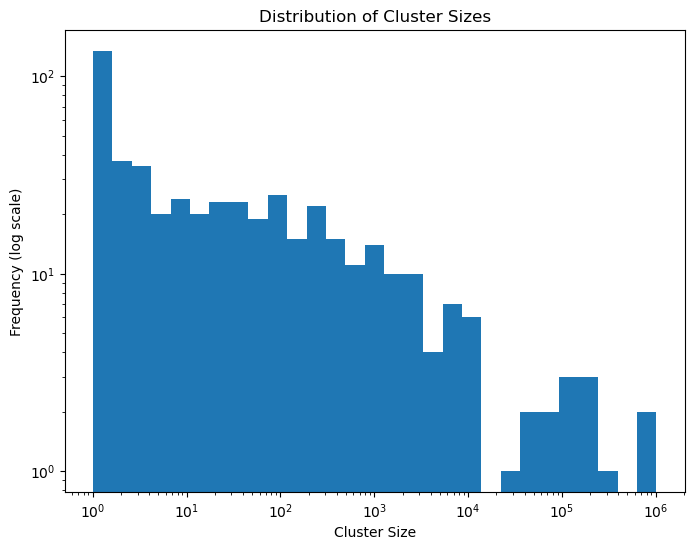

,Count
Cluster Size,
Size 1,134
Size 2,37
Size 3,19
Size 4,16
Size >4,282


In [321]:
import numpy as np

import matplotlib.pyplot as plt

print("Largest cluster sizes:", [clusters[c]['cluster_size'] for c in clusterIdsBySize[:10]])

cluster_sizes = [c['cluster_size'] for c in clusters.values()]

plt.figure(figsize=(8, 6))
plt.hist(cluster_sizes, bins=np.logspace(np.log10(1), np.log10(max(cluster_sizes)), 30), log=True)
plt.xscale('log')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Cluster Sizes')
plt.show()

cluster_counts = {
    'Size 1': 0,
    'Size 2': 0,
    'Size 3': 0,
    'Size 4': 0,
    'Size >4': 0
}

for size in cluster_sizes:
    if size == 1:
        cluster_counts['Size 1'] += 1
    elif size == 2:
        cluster_counts['Size 2'] += 1
    elif size == 3:
        cluster_counts['Size 3'] += 1
    elif size == 4:
        cluster_counts['Size 4'] += 1
    else:
        cluster_counts['Size >4'] += 1

cluster_table = pd.DataFrame.from_dict(cluster_counts, orient='index', columns=['Count'])
cluster_table.index.name = 'Cluster Size'
cluster_table

## Similarity histograms for the largest clusters

Plot histograms of the similarity index. It's intresting that most top out around 85%. That probably represents the ~15% error that happened to be present in the centroid read. 

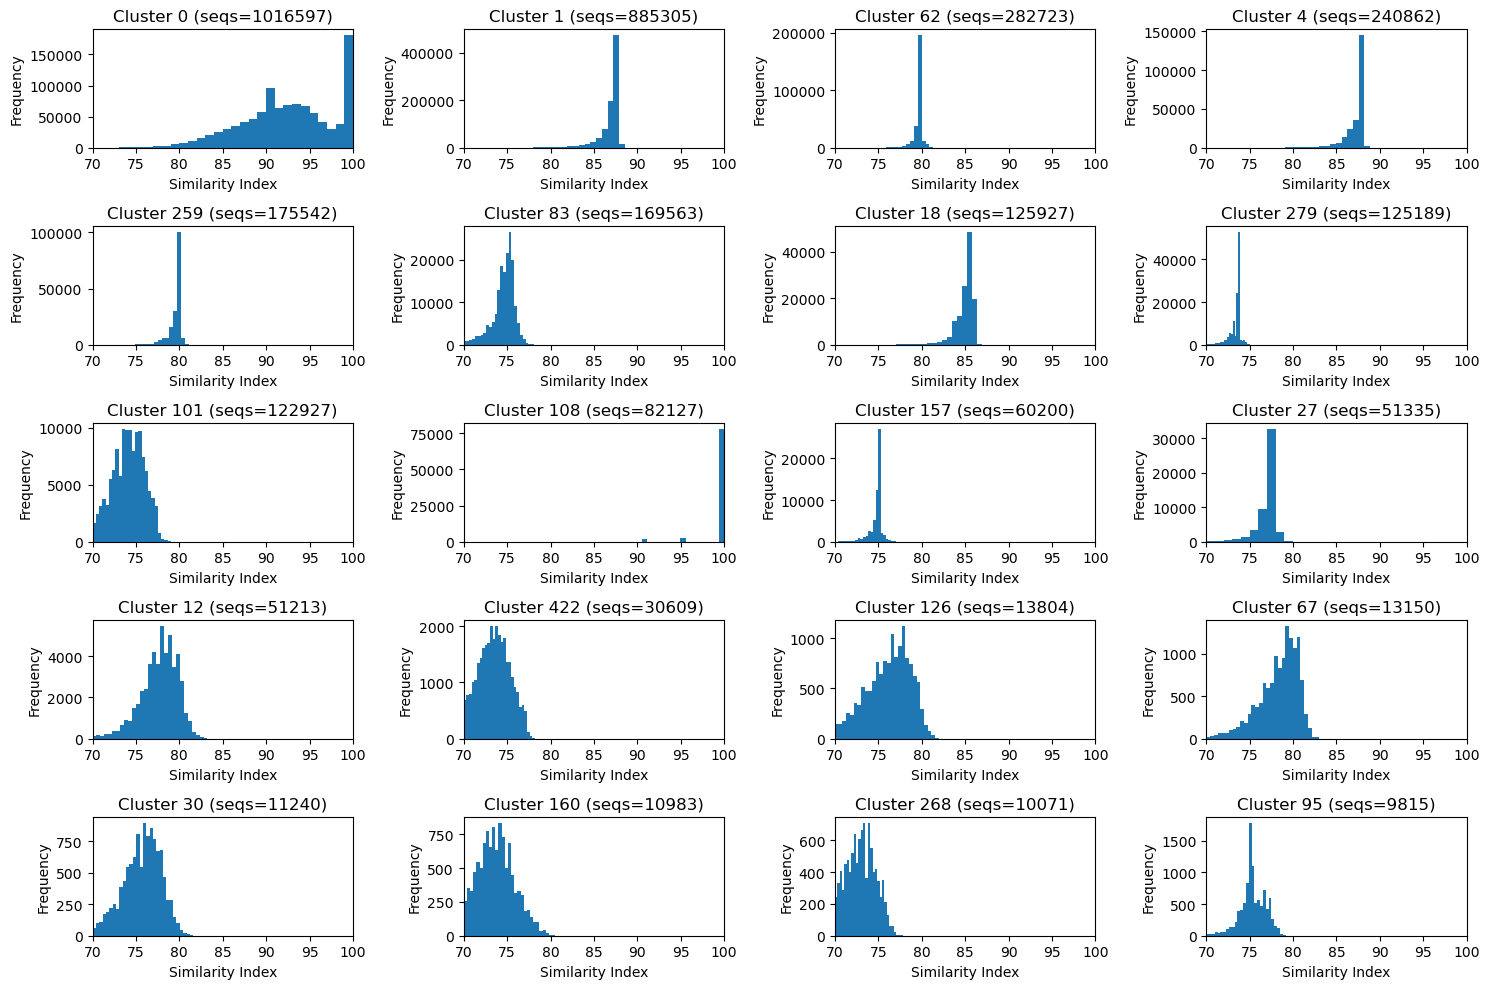

In [323]:
topClusters = [clusters[clusterIdsBySize[i]] for i in range(20)]

# plot a histogram of the similarity index for the first cluster
fig, axs = plt.subplots(5, 4, figsize=(15, 10))

for i, c in enumerate(topClusters):
    a = axs[i//4, i%4]
    a.set_xlim(70, 100)
    #a.set_ylim(0, 200000)
    similarity_indices = [float(hit['similarity']) for hit in c['hits']]
    a.hist(similarity_indices, bins=30)
    a.set_xlabel('Similarity Index')
    a.set_ylabel('Frequency')
    a.set_title(f'Cluster {c["id"]} (seqs={c["cluster_size"]})')

plt.tight_layout()
plt.show()


## Plot the barcode distribution of the top clusters

It looks like clusters do a pretty good job of being tied to a single barcode. Notable exceptions are barcode05/03 which turned out both to be nearly identical Rhinovirus-C11 and barcode01 which seems to be an odd mix of things.

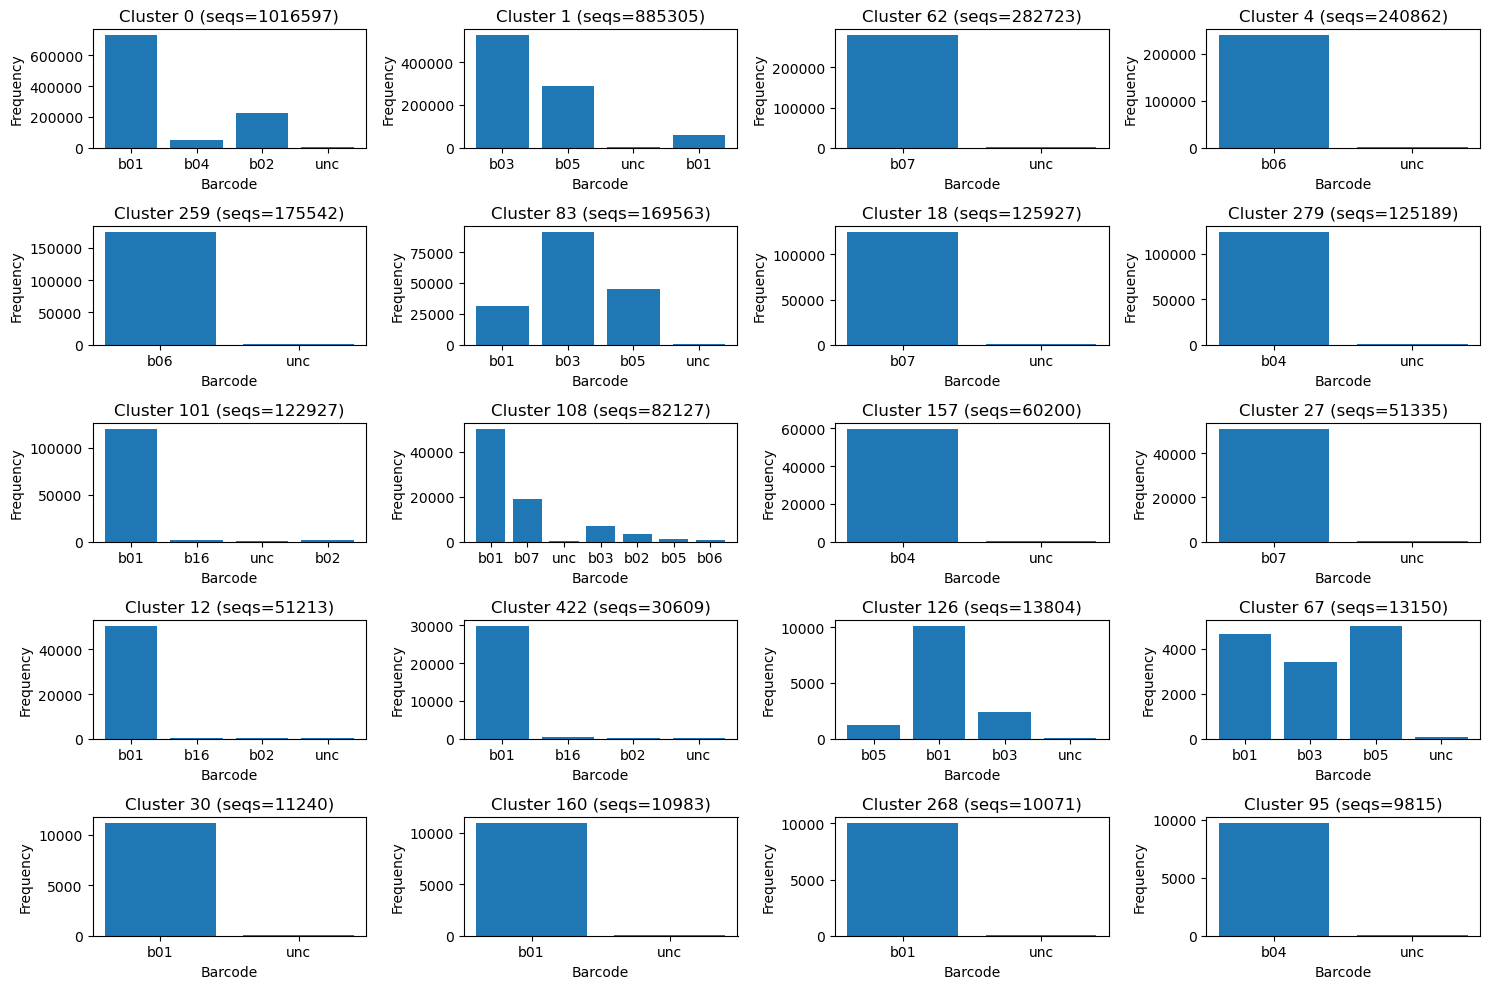

In [325]:
from collections import Counter

def short_name(name):
    if name.startswith('barcode'):
        return 'b' + name[7:]
    if name == 'unclassified':
        return 'unc'
    return name

fig, axs = plt.subplots(5, 4, figsize=(15, 10))

for i, c in enumerate(topClusters):
    barcodes = [hit['readId'].split('_')[1] for hit in c['hits']]
    barcode_counts = Counter(barcodes)
    total_size = c["cluster_size"]
    # remove any entries from the counter that are smaller than 0.1% of the total
    barcode_counts = {k: v for k, v in barcode_counts.items() if v > total_size * 0.001}    

    # shorten the barcode name
    keys = [short_name(k) for k in barcode_counts.keys()]

    a = axs[i//4, i%4]
    a.bar(keys, barcode_counts.values())
    a.set_xlabel('Barcode')
    a.set_ylabel('Frequency')
    a.set_title(f'Cluster {c["id"]} (seqs={total_size})')

plt.tight_layout()
plt.show()


# Dig into barcode01 clusters

It's clear from above that barcode01 doesn't fit cleanly into a single cluster like the other HRV sequences (2-7). Separately I have used minimap to produce single consensus sequences for each barcode. But minimap fails to produce a good consensus for barcode01 and inspecting the reads shows a high abundance of two different sequences which appear to be other samples we already have.

Try matching the highest quality reads from barcode01 against all of our existing HRV samples.

In [326]:
%%bash
cd ../Q8/reads-sup-hrv/
mkdir -p barcode01
cd barcode01 
# Get about the top 10%-20% quality reads
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --fastq_filter ../HRV-q8-sup_barcode01.fastq --fastq_qmax 50 --fastqout barcode01-hq.fastq --fastq_maxee 8.0
# Cluster them
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --cluster_size barcode01-hq.fastq --id 0.80 --consout barcode01-cluster-consensus.fasta --clusterout_sort 
sed 's/;seqs=/;size=/' barcode01-cluster-consensus.fasta > barcode01-cluster-consensus-size.fasta
# Then merge duplicates
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --derep_fulllength barcode01-cluster-consensus-size.fasta --output barcode01-derep.fasta --sizeout
# Now filter to only those with at least 10 reads
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --fastx_filter barcode01-derep.fasta --minsize 10 --fastaout barcode01-groups.fasta --sizeout

cat barcode01-groups.fasta myhrvs.fasta > toclustal.fasta

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading input file 100%
149324 sequences kept (of which 0 truncated), 1085394 sequences discarded.
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file barcode01-hq.fastq 100%
58562431 nt in 149324 seqs, min 316, max 457, avg 392
Masking 100%
Sorting by abundance 100%
Counting k-mers 100%
Clustering 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 15 Size min 1, max 57927, avg 9954.9
Singletons: 1, 0.0% of seqs, 6.7% of clusters
Multiple alignments 100%
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Dereplicating file barcode01-cluster-consensus-size.fasta 100%
5856 nt in 15 seqs, min 316, max 457, avg 390
Sorting 100%
15 unique sequences, avg cluster 9954.9, median 1198, max 57927
Writing FASTA output file 100%
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Rea

Running these with my HRV sequences in clustal omega, it's pretty clear that many are exact (or near-exact matches) to my own sequences - and so likely contamination not new targets. But there are a few outliers with lots of sequences.
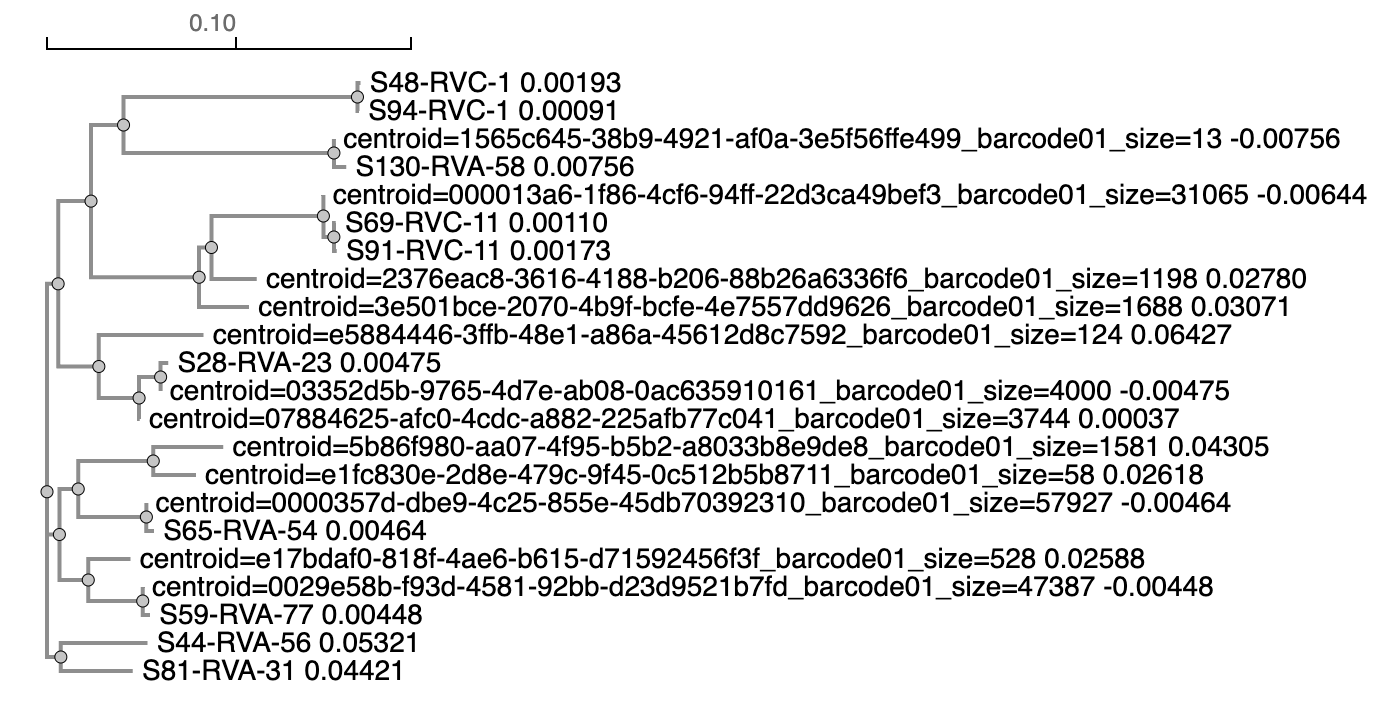

Doing a blast search on a couple outliers tends to return a combination of two of the targets I have (eg. RVA-77 and RVA-54) and so I suspect these are chimeric reads. No results appear for variants I have not yet seen in my samples.

## Look at how one of these outlier clusters matches sequences I have across it's length

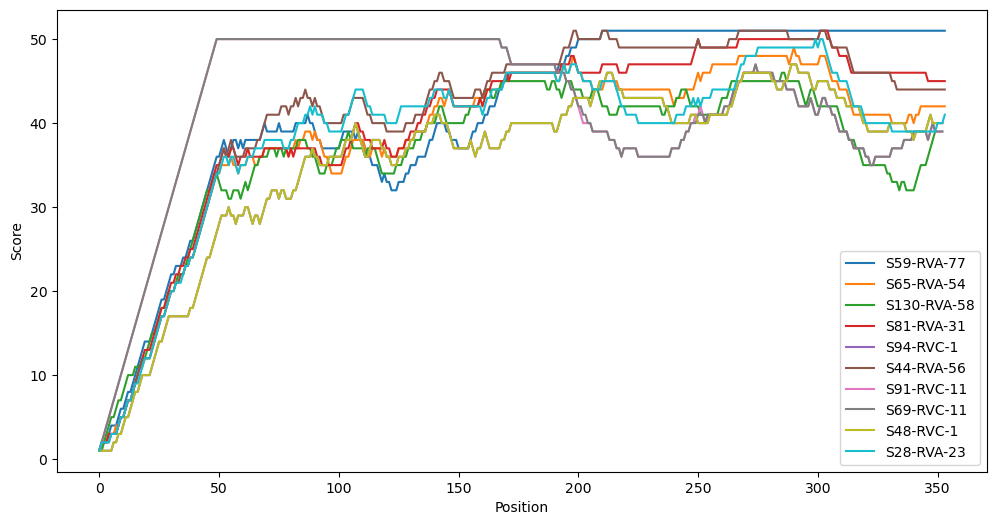

In [371]:
from Bio import SeqIO
import glob

bc1groups = list(SeqIO.parse(os.path.join(hrvDir, "barcode01", "barcode01-groups.fasta"), "fasta"))
[bc1o] = [r for r in bc1groups if r.id.endswith("size=1688")]

MVSIZE=50

def column_score(alignment, pos):
    #if alignment[0, pos] == '-' or alignment[1, pos] == '-':
    #   return -1
    return 1 if alignment[0, pos] == alignment[1, pos] else 0

# Compute an array of scores corresponding to a sliding window across the alignment.
# The output is exactly the length of the first sequence (so we can line up
# several different ones).
def sliding_window_scores(alignment, window_size):
    scores = []
    pos1_index = 0
    current_score = 0

    for ai in range(len(alignment[0])):
        current_score += column_score(alignment, ai)
        if alignment[0, ai] != '-':
            pos1_index += 1
            scores.append(current_score)

        if pos1_index >= window_size:
            # Subtract the score of the position that is sliding out of the window
            current_score -= column_score(alignment, ai - window_size + 1)

    return scores

def plotScores(target, seqs):
    aligner = RCUtils.getPrimerAligner()
    for seq in seqs:
        alignment = aligner.align(target.seq, seq.seq)[0]
        scores = sliding_window_scores(alignment, MVSIZE)
        plt.plot(scores, label=seq.id)
    plt.gcf().set_size_inches(12, 6)
    plt.xlabel("Position")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

# Load the known HRV sequences I have at this point in my analysis.
mySeqs = []
for file in ['S59-RVA-77.fastq',
            'S65-RVA-54.fastq',
            'S130-RVA-58.fastq',
            'S81-RVA-31.fastq',
            'S94-RVC-1.fastq',
            'S44-RVA-56.fastq',
            'S91-RVC-11.fastq',
            'S69-RVC-11.fastq',
            'S48-RVC-1.fastq',
            'S28-RVA-23.fastq']:
    mySeqs.extend(SeqIO.parse(os.path.join("myseqs", file), "fastq"))

plotScores(bc1o, mySeqs)

Simplify this by showing only the two lines that get max score

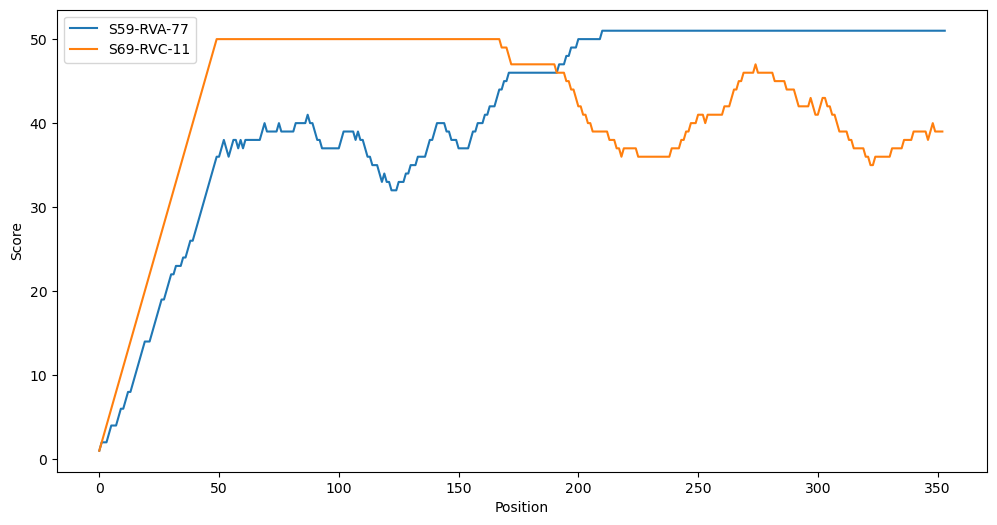

In [363]:
plotScores(bc1o, [s for s in mySeqs if s.id in ['S69-RVC-11', 'S59-RVA-77']])

This is definitely some sort of chimera. It's surprising to me that there would be so many matching reads for this. Is this perhaps a PCR error?

Let's check another example.

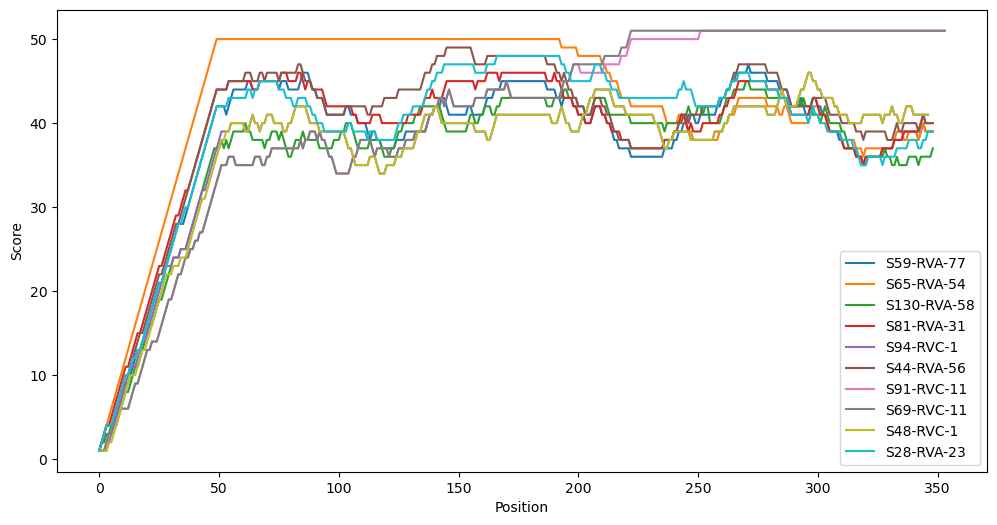

In [367]:
[bc1o] = [r for r in bc1groups if r.id.endswith("size=1581")]
plotScores(bc1o, mySeqs)

This looks like the same sort of thing but with S65 and S69 this time instead of S69 and S59.

## Compute an any-sequence match score for each group consensus sequence

We're looking for clutsers which don't appear to match a known sequence or chimera of known sequences.

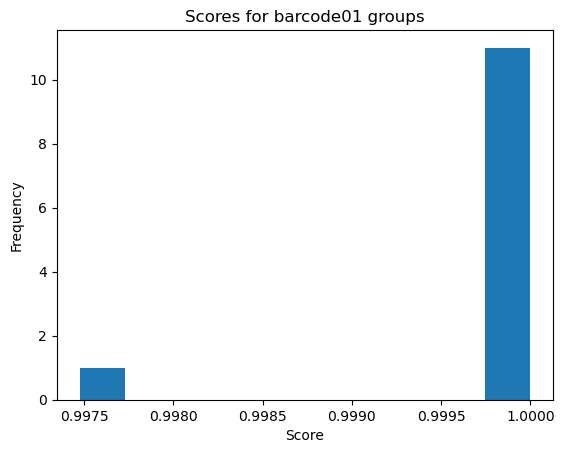

In [314]:
def compute_any_match(target, queries):
    # Compute a pairwise alignment for each query
    aligner = RCUtils.getPrimerAligner()
    alignments = [aligner.align(target.seq, query.seq)[0] for query in queries]
    
    # Walk the target sequence and check if any of the queries match at each position
    # Note that this doesn't handle the case of a gap in the target sequence, but it's
    # likely good enough.
    score = 0
    scores = []
    for ti in range(len(target.seq)):
        for a in alignments:
            ai = a.inverse_indices[0][ti]
            if ai != -1 and a[0,ai] == a[1,ai]:
                score += 1
                break
        scores.append(score)
    return (score / len(target.seq), scores)

# The target sequences include primers, but mySeqs generally do not.
hrvSeqs = list(mySeqs)
hrvSeqs.append(hrvPrimers[0])
hrvSeqs.append(hrvPrimers[1].reverse_complement())

scoredGroups = [(g,)+compute_any_match(g, hrvSeqs) for g in bc1groups]

# plot a histogram of the scores
scores = [s for (g,s,_) in scoredGroups]
plt.hist(scores, bins=10)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Scores for barcode01 groups')
plt.show()

Ok that looks pretty much perfect. The one mismatch appears to be an off-by-one error at the end or something, not worth digging into.

## Summarize how barcode01 reads match existing targets

Use VSearch to map each barcode01 read to one of our existing targets.

In [176]:
%%bash
cd ../Q8/reads-sup-hrv/
mkdir -p barcode01
cd barcode01 
cat ../../../RespiCov-analyze/myseqs/*RV*.fastq > myhrvs.fastq
# --gapopen 0ET allows the query to match the full target (null gap open/close penalties on the target extremities)
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode01.fastq --db myhrvs.fastq --id 0.80 --gapopen 0ET --gapext 0ET --notmatched myhrvs_notmatched.fastq --strand both --blast6out myhrvs.blast6

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file myhrvs.fastq 100%
3513 nt in 10 seqs, min 348, max 354, avg 351
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 832753 of 1234718 (67.44%)
Searching 100%
Matching unique query sequences: 1216244 of 1234718 (98.50%)


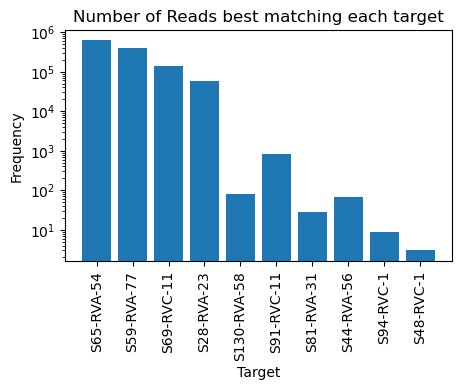

In [184]:
# Read the blast6 output, a tab separated file with the following columns:
# 1. Query ID
# 2. Target ID
# 3. Percent identity
matchesByRead = {}
scoresByTarget = {}
with open(os.path.join(hrvDir, "barcode01/myhrvs.blast6")) as f:
    for line in f:
        columns = line.strip().split('\t')
        readId = columns[0]
        target = columns[1]
        score = float(columns[2])
        matchesByRead[readId] = {
            'target': target,
            'identity': score
        }
        if target not in scoresByTarget:
            scoresByTarget[target] = []
        scoresByTarget[target].append(score)

# Plot a histogram of the number of reads for each target
target_counts = Counter([match['target'] for match in matchesByRead.values()])
plt.figure(figsize=(5, 3))
plt.bar(target_counts.keys(), target_counts.values())
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.tick_params(axis='x', rotation=90)
plt.yscale('log')  # Set y-axis to log scale
plt.title('Number of Reads best matching each target')
plt.show()

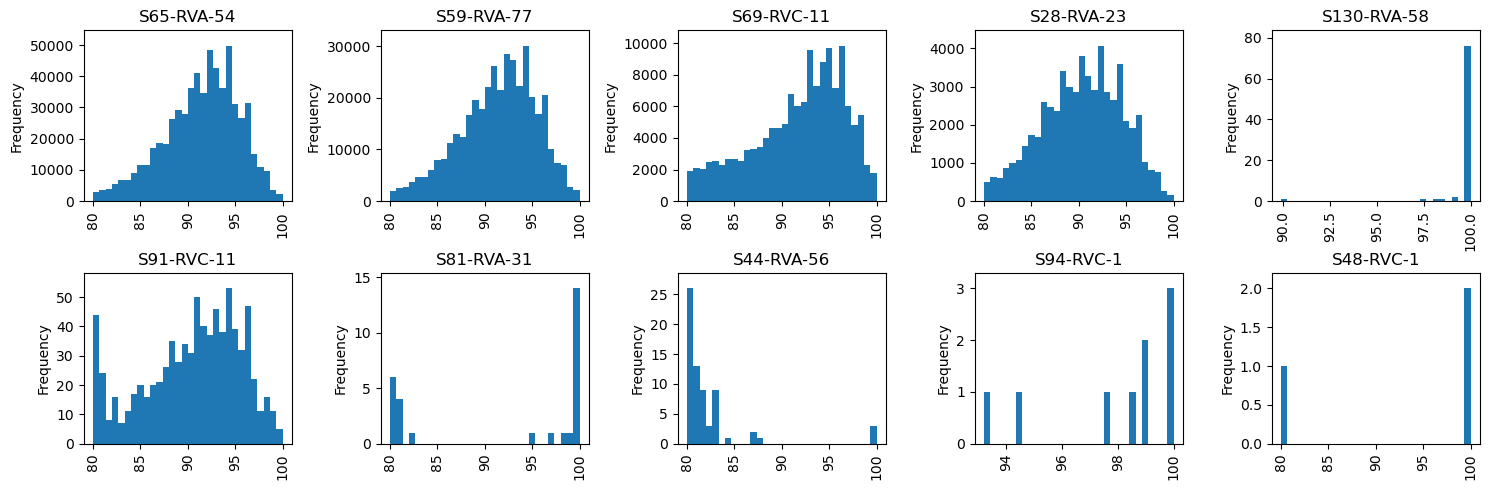

In [189]:
# Plot histogram of the match scores against each target
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, tgt in enumerate(list(scoresByTarget.keys())):
    a = axs[i//5, i%5]
    identity_values = [match['identity'] for match in matchesByRead.values() if match['target'] == tgt]
    a.hist(identity_values, bins=30)
    a.set_ylabel('Frequency')
    a.set_title(tgt)
    a.tick_params(axis='x', rotation=90)
    a.margins(y=0.1)  # Add vertical space

plt.tight_layout()
plt.show()


So this looks like mostly a mix of probably 4 existing samples, likely contamination. There are a handful of other high-quality matches for other samples, but that's likely just incorrect barcoding or chimeric reads. 

# Examine all clusters for unknown HRV sequences

Repeat some of the above techniques for the rest of the clusters we found (much noiser).

## Remove all the clusters of size 5 or less

These are too small to have a high quality consensus, and likely just represent an unlucky string of errors.

In [355]:
%%bash
cd ../Q8/reads-sup-hrv/clusters
sed 's/;seqs=/;size=/' consensus.fasta > consensus-size.fasta
# merge duplicates
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --derep_fulllength consensus-size.fasta --output consensus-derep.fasta --sizeout
# Now filter to only those with at least 4 reads
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --fastx_filter consensus-derep.fasta --minsize 6 --fastaout consensus-min.fasta --sizeout


vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Dereplicating file consensus-size.fasta 100%
182146 nt in 484 seqs, min 40, max 452, avg 376
minseqlength 32: 4 sequences discarded.
Sorting 100%
478 unique sequences, avg cluster 7437.3, median 9, max 1016597
Writing FASTA output file 100%
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading input file 100%
266 sequences kept (of which 0 truncated), 212 sequences discarded.


## Compute any-match scores for these cluster consensus sequences

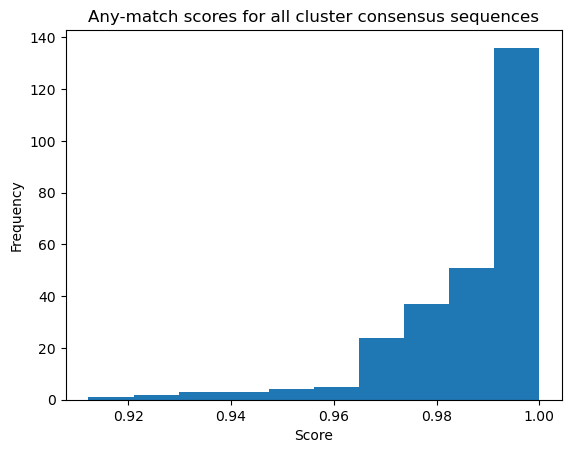

In [357]:
consMin = list(SeqIO.parse(os.path.join(hrvDir, "clusters", "consensus-min.fasta"), "fasta"))
scoredGroups = [(c,)+compute_any_match(c, hrvSeqs) for c in consMin]

# plot a histogram of the scores
scores = [s for (g,s,_) in scoredGroups]
plt.hist(scores, bins=10)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Any-match scores for all cluster consensus sequences')
plt.show()

Get the sequence IDs for the lowest scoring groups and look at how they match existing samples.

score 0.912
>centroid=e942f50f-d11f-48f5-803b-f5fcb41b6b42_barcode03;size=7
CAAGCACTTCTGTTTCCCCGGCATGTGAGGAATAGGCTCCAAAAGGGCTAAAGCCACTAGTGTCGTTATCCGCATTGGTACTACGCAAAGCCTAGTATCACTCTGGAAGTCTCTCGGTTGGTCGCTCCACCAGCCACCCCACGGTAGACCCGGCAGATGAAGGGCAGGCCTCCCCCACGGGTGAGTGGTCCTGCCTGCGTGGCTGCCGGAAAACCCACACGGGGTGTGAAGGGGAGAAAGGGAGGTGAGTCCTCCCAGCTACCATGAGCTACCAAGGAGGACTTCCGCCCCAATACGGCGCCAAACTTACCCCACAGCTGTTGCACGCAGTCCAGCGTGTATGCAGTCGTAATGAGCAATTGTGGGACGGAAACCCCAACTACTCTGGGTGTCCGTGTT


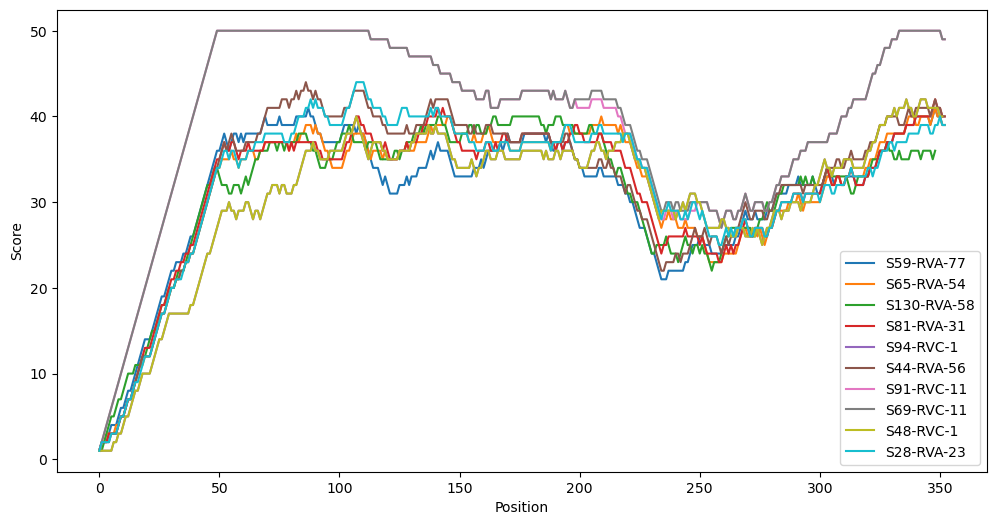

In [375]:
groupsByScore = sorted(scoredGroups, key=lambda x: x[1])

def dumpGroup(e):
    print("score %.3f" % (e[1]))
    print(">%s" % e[0].id)
    print(e[0].seq)
    plotScores(e[0], mySeqs)

dumpGroup(groupsByScore[0])


This one has a similar blast result to S69, perhaps there's a chimera in the middle or just other noise? 

score 0.921
>centroid=1e2f8ec0-e512-433c-b262-2e681d2b8114_unclassified;size=283
CAAGCACTTCTGTTTCCCCGGGACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTGACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTTACTACTTTGGGTGTCCGTGTT


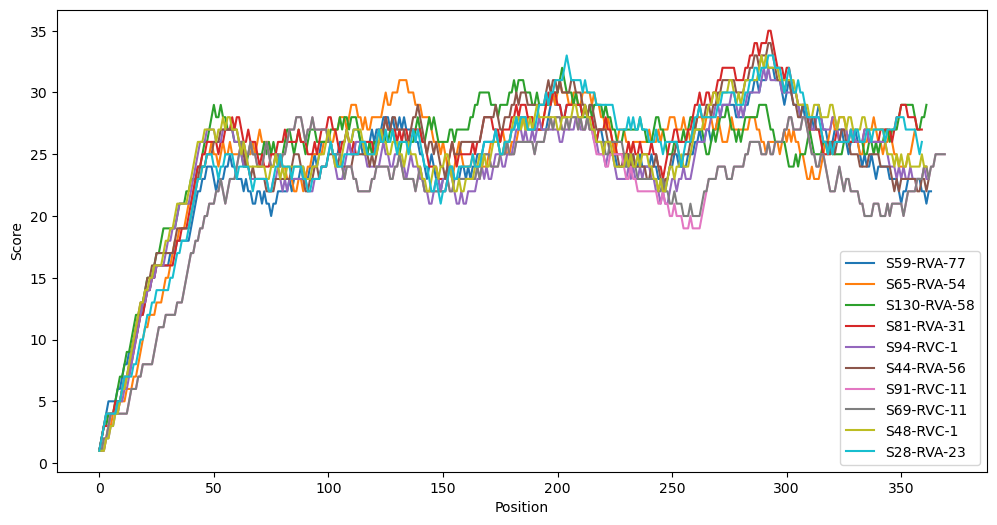

In [374]:
dumpGroup(groupsByScore[1])

This result has no BLAST matches at all, strange.

Look at a few of the higher scoring ones but less than 1.0

score 0.997
>centroid=54772b86-6111-4a5a-b89a-2480387d1f2c_barcode01;size=323
CAAGCACTTCTGTTTCCCCGGTCAATGCTGATATGCTCCACCAGGGCAAACAGCAGAGATCGTTATCCGCAAGGTGCCTACGCAAAGCTTAGTAGCATTTTGAAGAACATTTGGTTGGTCGCTCAGCTATTTTCCTATATAGACGGCAGATGAGGCTAGAAGTCCCCCACTGGCGACAGTGTCCAGCCTGCGTGCGCTCTTTTGAGTGCGAGGCATGTTTGACAAGGTGTGAAGAGCCCCGTGTGCTCACCTTGAGTCCTCCGGCCCCTGAATGTGGCTAACCTTAACCCTGCAGCTAGTGCATGAAAACCATCTGTAGCTATCGTAATGAGCAATTGCGGGATGGACCAACTACTTTGGGTGTCCGTGTT


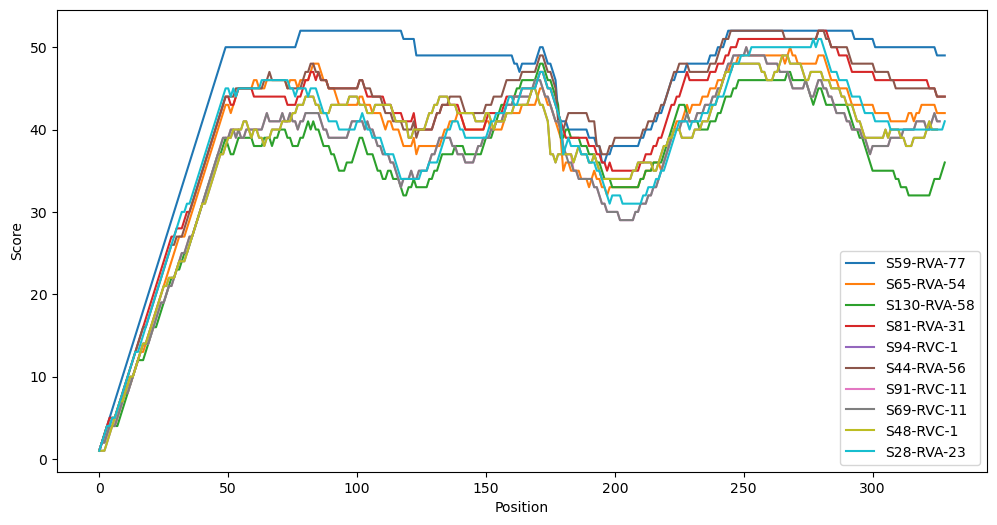

In [373]:
dumpGroup(groupsByScore[200])


This just matches S59 but with lots of regular gaps. This seems like a PCR error where the polymerase slipped a bunch. 

score 0.987
>centroid=6eadcef6-2a30-48c5-9a56-b032ee122e81_barcode01;size=32
CAAGCACTTCTGTTTCCCGGTGAATGCTGATATGCTCCACCAGGGCAAAAACAGCAGAGATCGTTATCCGCAAGGTGCTTCCCCAAAGCTTAGTAGCATTTGAAGAACTAGTTGGTGGCTCATTTGCTGTAGACCTGGCAGATGAGCTCAGAGTCCCACTGGCGACAGTGTTCTCGCCTGCGTGGCTGCCTGCGCACTTTTTGAGTGCGAAGCCATATGTTTGACAAGGTGTGAAGAGCCCCGTGTGCTCACCTTGAGTCCTCCGGCCCCTGAATGTGGCTAACCTTAACCCCTGCAGCTAGTGCATGAAAACCATCATGTGGCTAGTGCGTAATGAGCAGATTGGGGATGGGCAACTACTTGGGTGTCCGTGTT


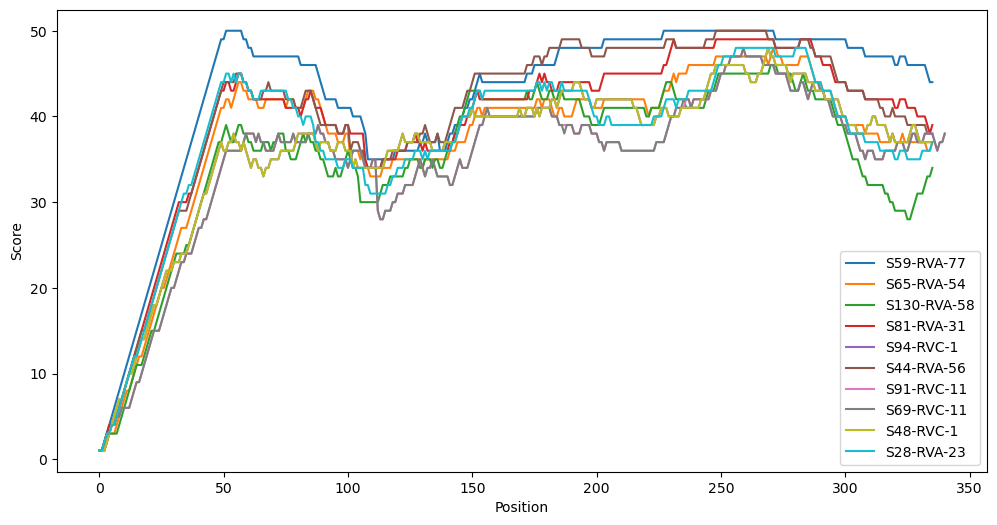

In [372]:
dumpGroup(groupsByScore[102])

This also matches S59 but with regular gaps. 

This doesn't seem useful to continue exploring, I'm just finding different PCR artifacts which seem hard to filter out. A lot of this junk is in barcode01. Let's just focus on the barcodes I don't have any matches for yet. 

# Dig into barcode19 

In [376]:
%%bash
cd ../Q8/reads-sup-hrv/
mkdir -p barcode19
cd barcode19
# Get about the top quality reads
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --fastq_filter ../HRV-q8-sup_barcode19.fastq --fastq_qmax 50 --fastqout barcode19-hq.fastq --fastq_maxee 8.0
# Cluster them
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --cluster_size barcode19-hq.fastq --id 0.80 --consout barcode19-cluster-consensus.fasta --clusterout_sort 
sed 's/;seqs=/;size=/' barcode19-cluster-consensus.fasta > barcode19-cluster-consensus-size.fasta
# Then merge duplicates
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --derep_fulllength barcode19-cluster-consensus-size.fasta --output barcode19-derep.fasta --sizeout
# Now filter to only those with at least 10 reads
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --sizein --fastx_filter barcode19-derep.fasta --minsize 10 --fastaout barcode19-groups.fasta --sizeout


vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading input file 100%
58 sequences kept (of which 0 truncated), 8 sequences discarded.
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file barcode19-hq.fastq 100%
22846 nt in 58 seqs, min 382, max 402, avg 394
Masking 100%
Sorting by abundance 100%
Counting k-mers 100%
Clustering 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 4 Size min 10, max 21, avg 14.5
Singletons: 0, 0.0% of seqs, 0.0% of clusters
Multiple alignments 100%
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Dereplicating file barcode19-cluster-consensus-size.fasta 100%
1576 nt in 4 seqs, min 392, max 396, avg 394
Sorting 100%
4 unique sequences, avg cluster 14.5, median 14, max 21
Writing FASTA output file 100%
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading input file 100%
4 sequence

In [387]:
import pandas as pd

b19c = list(SeqIO.parse(os.path.join(hrvDir, "barcode19", "barcode19-groups.fasta"), "fasta"))

# Given a target, return a tuple of the query ID with the highest score and the score
def match_to_known(target, queries):
    aligner = RCUtils.getPrimerAligner()
    scores = [(q.id, aligner.align(target.seq, q.seq)[0].score/len(q.seq)) for q in queries]
    return max(scores, key=lambda x: x[1])

# Print a table of the best match and score for each group
data = []
for g in b19c:
    (match, score) = match_to_known(g, mySeqs)
    size = int(g.id.split('=')[2])
    data.append({'Size': size, 'Best Match': match, 'Score': score})
pd.DataFrame(data)

,Size,Best Match,Score
0,21,S69-RVC-11,1.000000
1,14,S65-RVA-54,0.968571
2,13,S130-RVA-58,1.000000
3,10,S94-RVC-1,1.000000


In [388]:
%%bash
cd ../Q8/reads-sup-hrv/barcode19/
cat ../../../RespiCov-analyze/myseqs/*RV*.fastq > myhrvs.fastq
# --gapopen 0ET allows the query to match the full target (null gap open/close penalties on the target extremities)
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode19.fastq --db myhrvs.fastq --id 0.80 --gapopen 0ET --gapext 0ET --notmatched myhrvs_notmatched.fastq --strand both --blast6out myhrvs.blast6

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file myhrvs.fastq 100%
3513 nt in 10 seqs, min 348, max 354, avg 351
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 66 of 66 (100.00%)


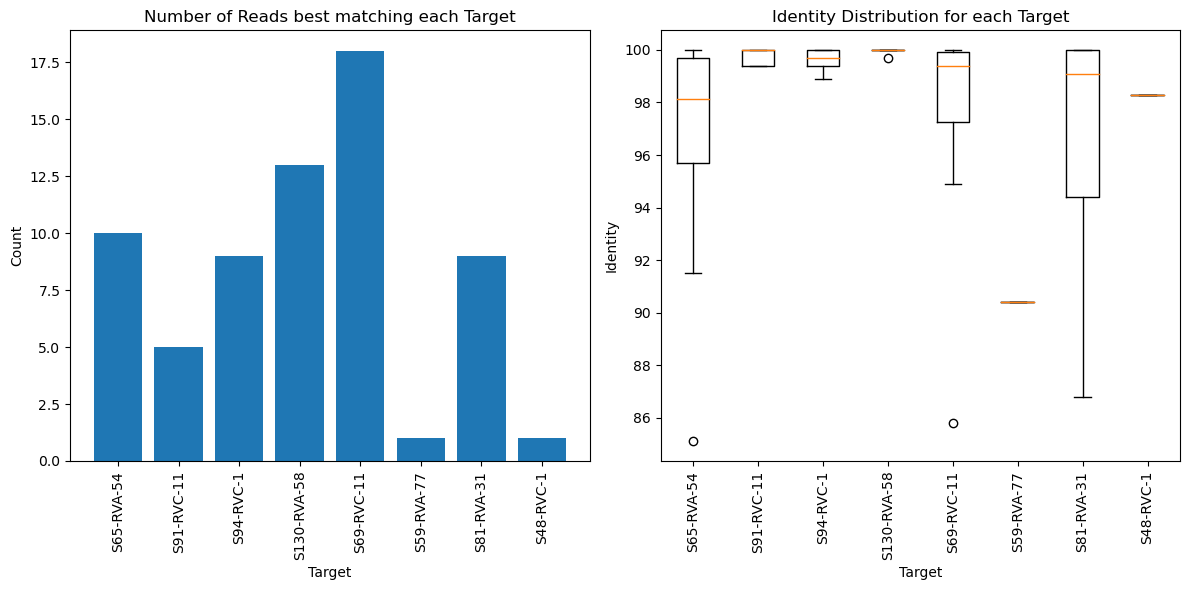

In [424]:
matchesByRead = {}
with open(os.path.join(hrvDir, "barcode19/myhrvs.blast6")) as f:
    for line in f:
        (readId, target, score, *_) = line.strip().split('\t')
        matchesByRead[readId] = {
            'target': target,
            'identity': float(score)
        }

# Create a list of identity values for each target
target_counts = Counter([match['target'] for match in matchesByRead.values()])
identity_values = []
for target in target_counts.keys():
    identities = [match['identity'] for match in matchesByRead.values() if match['target'] == target]
    identity_values.append(identities)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot of target counts
ax1.bar(target_counts.keys(), target_counts.values())
ax1.set_xlabel('Target')
ax1.set_ylabel('Count')
ax1.set_title('Number of Reads best matching each Target')
ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Box and whisker plot
ax2.boxplot(identity_values, labels=target_counts.keys())
ax2.set_xlabel('Target')
ax2.set_ylabel('Identity')
ax2.set_title('Identity Distribution for each Target')
ax2.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()


In [425]:
# Filter the given fastq file, writing only the specified read IDs to a new fastq file
def filter_fastq_by_id(input_file, output_file, read_ids):
    wrote = 0
    with open(output_file, 'w') as out:
        for read in SeqIO.parse(input_file, 'fastq'):
            if read.id in read_ids:
                SeqIO.write(read, out, 'fastq')
                wrote += 1
    print("Wrote", wrote, "reads to", output_file)

# Write the reads matching S65-RVA-54 and S81-RVA-31 to new fastq files
w = filter_fastq_by_id(os.path.join(hrvDir, "HRV-Q8-sup_barcode19.fastq"), 
                   os.path.join(hrvDir, "barcode19", "barcode19-RVA54.fastq"),
                   [read_id for read_id, match in matchesByRead.items() if match['target'] == 'S65-RVA-54'])
w = filter_fastq_by_id(os.path.join(hrvDir, "HRV-Q8-sup_barcode19.fastq"), 
                   os.path.join(hrvDir, "barcode19", "barcode19-RVA31.fastq"),
                   [read_id for read_id, match in matchesByRead.items() if match['target'] == 'S81-RVA-31'])

Wrote 10 reads to ../Q8/reads-sup-hrv/barcode19/barcode19-RVA54.fastq
Wrote 9 reads to ../Q8/reads-sup-hrv/barcode19/barcode19-RVA31.fastq


Generating consensus sequences from these, they indeed match exactly S65 and S81 and so are almost certainly just bleeding across barcodes. This also indicates that it's risky to rely on the consensus sequences generated from clustering. The cluster we looked at probably contained a mix of these two sequences. 

# Dig into barcode20

TODO: In trying to also match against refseq, my strong matches for HRV-C11 appear to get turned into weak matches for C43 or C8. Is Vsearch matching not looking for the best match? Should I just do my own pairwise alignments?

In [418]:
%%bash
cd ../Q8/reads-sup-hrv
mkdir barcode20
cd barcode20
cat ../../../RespiCov-analyze/myseqs/*RV*.fastq > myhrvs.fastq
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --fastq_filter myhrvs.fastq --fastaout myhrvs.fasta --fastq_qmax 93

# --gapopen 0ET allows the query to match the full target (null gap open/close penalties on the target extremities)
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode20.fastq --db myhrvs.fastq --id 0.85 --gapopen 0ET --gapext 0ET --notmatched myhrvs_notmatched.fastq --strand both --blast6out myhrvs.blast6

mkdir: barcode20: File exists
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading input file 100%
10 sequences kept (of which 0 truncated), 0 sequences discarded.
vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file myhrvs.fastq 100%
3513 nt in 10 seqs, min 348, max 354, avg 351
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 133 of 141 (94.33%)


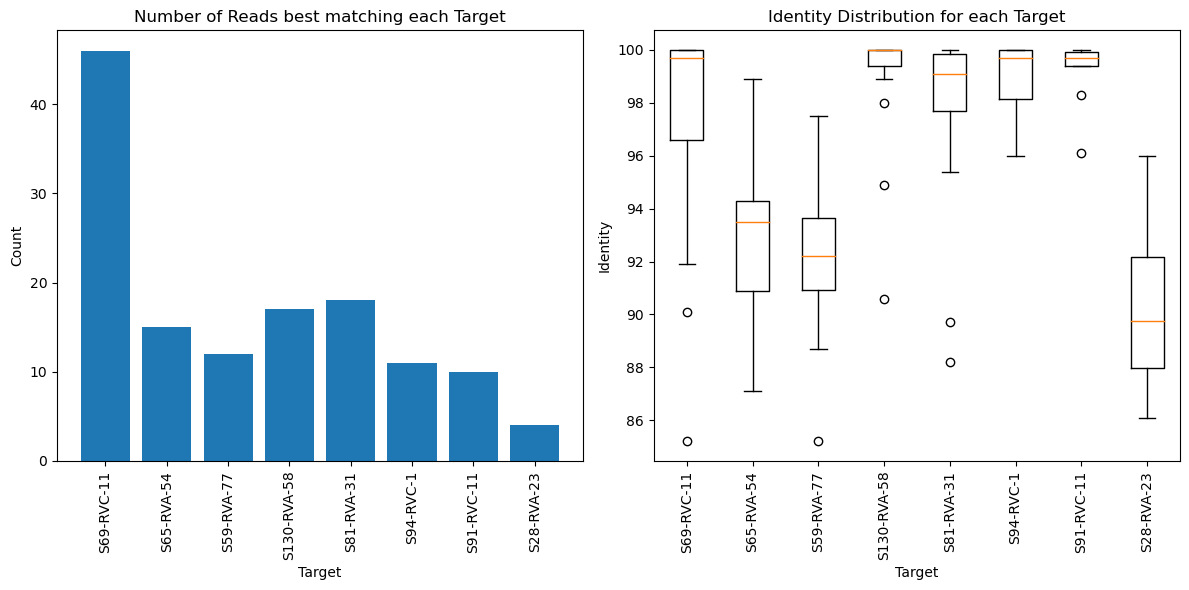

In [419]:
matchesByRead = {}
with open(os.path.join(hrvDir, "barcode20/myhrvs.blast6")) as f:
    for line in f:
        (readId, target, score, *_) = line.strip().split('\t')
        matchesByRead[readId] = {
            'target': target,
            'identity': float(score)
        }

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot of target counts
target_counts = Counter([match['target'] for match in matchesByRead.values()])
target_counts = {k: v for k, v in target_counts.items() if v > 3}
ax1.bar(target_counts.keys(), target_counts.values())
ax1.set_xlabel('Target')
ax1.set_ylabel('Count')
ax1.set_title('Number of Reads best matching each Target')
ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Create a list of identity values for each target
identity_values = []
for target in target_counts.keys():
    identities = [match['identity'] for match in matchesByRead.values() if match['target'] == target]
    identity_values.append(identities)

# Box and whisker plot
ax2.boxplot(identity_values, labels=target_counts.keys())
ax2.set_xlabel('Target')
ax2.set_ylabel('Identity')
ax2.set_title('Identity Distribution for each Target')
ax2.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()


In [431]:
%%bash
cd ../Q8/reads-sup-hrv/barcode20
cat ../../../RespiCov-analyze/refseq/Rhinovirus-all.fasta myhrvs.fasta > allhrvs.fasta

# --gapopen 0ET allows the query to match the full target (null gap open/close penalties on the target extremities)
#../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode20.fastq --db allhrvs.fasta --id 0.85 --gapopen 0ET --gapext 0ET --notmatched myhrvs_notmatched.fastq --strand both --blast6out allhrvs.blast6
../../../vsearch-2.28.1-macos-aarch64/bin/vsearch --usearch_global ../HRV-q8-sup_barcode20.fastq --db allhrvs.fasta --id 0.75 --notmatched myhrvs_notmatched.fastq --strand both --blast6out allhrvs.blast6

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file allhrvs.fasta 100%
963377 nt in 145 seqs, min 348, max 7233, avg 6644
Masking 100%
Counting k-mers 100%
Creating k-mer index 100%
Searching 100%
Matching unique query sequences: 140 of 141 (99.29%)


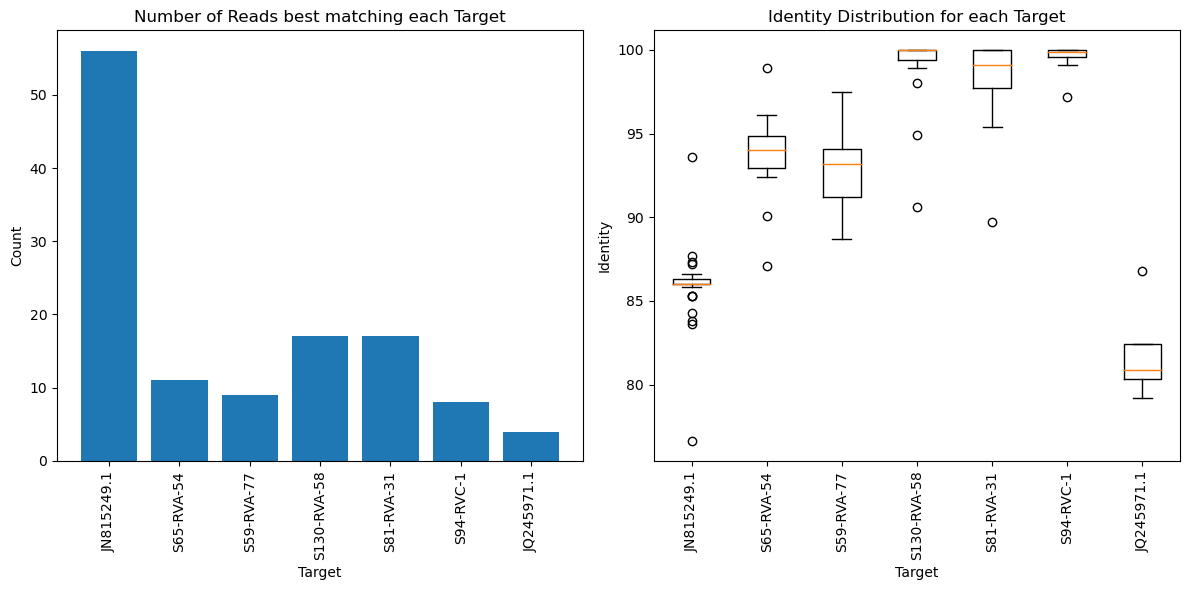

In [432]:
matchesByRead = {}
with open(os.path.join(hrvDir, "barcode20/allhrvs.blast6")) as f:
    for line in f:
        (readId, target, score, *_) = line.strip().split('\t')
        matchesByRead[readId] = {
            'target': target,
            'identity': float(score)
        }

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot of target counts
target_counts = Counter([match['target'] for match in matchesByRead.values()])
target_counts = {k: v for k, v in target_counts.items() if v > 3}
ax1.bar(target_counts.keys(), target_counts.values())
ax1.set_xlabel('Target')
ax1.set_ylabel('Count')
ax1.set_title('Number of Reads best matching each Target')
ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Create a list of identity values for each target
identity_values = []
for target in target_counts.keys():
    identities = [match['identity'] for match in matchesByRead.values() if match['target'] == target]
    identity_values.append(identities)

# Box and whisker plot
ax2.boxplot(identity_values, labels=target_counts.keys())
ax2.set_xlabel('Target')
ax2.set_ylabel('Identity')
ax2.set_title('Identity Distribution for each Target')
ax2.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()


In [428]:
w = filter_fastq_by_id(os.path.join(hrvDir, "HRV-Q8-sup_barcode20.fastq"), 
                   os.path.join(hrvDir, "barcode20", "barcode20-RVC43.fastq"),
                   [read_id for read_id, match in matchesByRead.items() if match['target'] == 'JN815249.1'])


Wrote 48 reads to ../Q8/reads-sup-hrv/barcode20/barcode20-RVC43.fastq


### Generate the Rhinovirus-All.fasta file

In [456]:
import os
import glob
from Bio import SeqIO
import re

# Read all FASTA files named Rhinovirus-*.fasta in the refseq directory and output a single FASTA file containing all sequences
# with the sequence ID modified to include the file name.

def filename_key(filepath):
    match = re.search(r"(.*)-(.)(\d+)\.fasta", filepath)
    if match == None:
        return (filepath,"",0)
    return match.group(1), match.group(2), int(match.group(3))

with open("refseq/Rhinovirus-All.fasta", "w") as outfile:
    for filepath in sorted(glob.glob("refseq/Rhinovirus-*.fasta"), key=filename_key):
        if filepath.split(("-"))[-1].lower() == "all.fasta":
            continue
        record = SeqIO.read(filepath, "fasta")
        record.id = os.path.basename(filepath).rsplit(".", 1)[0]
        SeqIO.write(record, outfile, "fasta")
